# Optiland Torch Module - Custom Objective

This notebook demonstrates a more advanced feature: defining a **custom objective function**. Instead of just minimizing RMS spot size, we'll create a composite objective that simultaneously minimizes the spot size and penalizes the total length of the optical system. This showcases the flexibility of combining Optiland with PyTorch for complex design goals.

In [1]:
import torch
import matplotlib.pyplot as plt
import optiland.backend as be
from optiland import optic, optimization
from optiland.ml import OpticalSystemModule
from optiland.wavefront import ZernikeOPD

be.set_backend("torch")  # Set the backend to PyTorch
be.grad_mode.enable()  # Enable gradient tracking

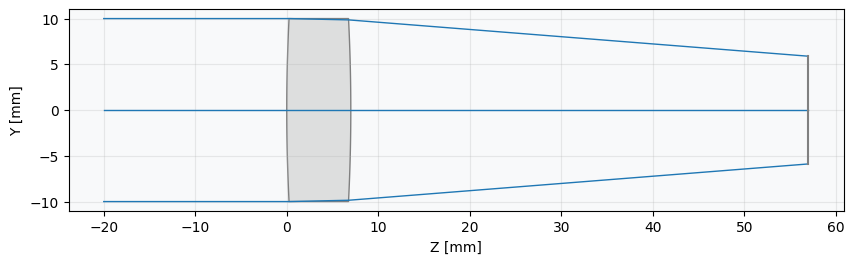

In [2]:
lens = optic.Optic()
lens.add_surface(index=0, thickness=be.inf)
lens.add_surface(index=1, thickness=7, radius=200, material="N-SF11", is_stop=True)
lens.add_surface(index=2, thickness=50, radius=-200)
lens.add_surface(index=3)
lens.set_aperture(aperture_type="EPD", value=20)
lens.set_field_type(field_type="angle")
lens.add_field(y=0.0)
lens.add_wavelength(value=0.55, is_primary=True)
_ = lens.draw()

## Build optimization problem

First, we set up the standard optimization problem. We'll define the RMS spot size as our primary operand and the lens radii as variables. The custom objective will build upon this foundation.

In [3]:
problem = optimization.OptimizationProblem()
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0, "Hy": 0,
    "num_rays": 7,
    "wavelength": 0.55,
    "distribution": "hexapolar",
}
problem.add_operand("rms_spot_size", target=0, weight=1, input_data=input_data)
problem.add_variable(lens, "radius", surface_number=1)
problem.add_variable(lens, "radius", surface_number=2)

Define a Custom Objective Function

This is the core of this example. We create a Python function that returns our desired loss value. This function can perform any calculation using the underlying Optiland objects. Our objective will be:

$$ \text{Loss} = (\text{RMS Spot Size})^2 + \lambda \cdot (\text{Total System Length}) $$

where $\lambda$ is a weighting factor to balance the two terms.

In [4]:
def custom_objective():
    """
    Custom objective that minimizes both RMS spot size and total system length.
    """
    # Calculate the sum of squared errors from the optimization problem (our spot size term)
    spot_size_term = problem.sum_squared()
    
    # Add a penalty term proportional to the total length (total_track) of the lens
    # The 1e-3 factor balances the magnitude of the two terms in the loss function.
    length_penalty = 1e-3 * lens.total_track
    
    return spot_size_term + length_penalty

## Define PyTorch module in Optiland

We now pass our custom function to the `OpticalSystemModule` using the `objective_fn` argument. The module will call this function during its forward pass to compute the loss.

In [5]:
model = OpticalSystemModule(lens, problem, objective_fn=custom_objective)

## Define PyTorch Adam Optimizer and pass model parameters

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.3)

## Optimize with PyTorch

In [7]:
losses = []

for step in range(100):
    optimizer.zero_grad()         # Clear gradients
    loss = model()                # Forward pass computes RMS spot size
    loss.backward()               # Backward pass computes gradients
    optimizer.step()              # Update model parameters
    model.apply_bounds()          # Apply parameter bounds
    losses.append(loss.item())

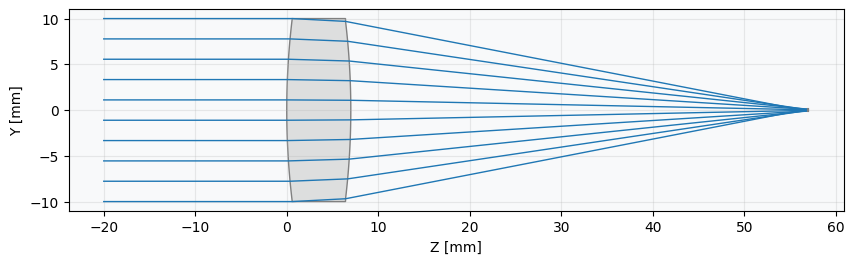

In [8]:
_ = lens.draw(num_rays=10)